<a href="https://colab.research.google.com/github/olwflynn/Learning/blob/master/Learning%20Physics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install dependencies

!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

!pip install gym free-mujoco-py mujoco torch

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-dev set to manually installed.
software-properties-common is already the newest version (0.96.24.32.18).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  glew-utils
The following NEW packages will be installed:
  libgl1-mesa-glx libglew-dev libglew2.0 libosmesa6 libosmesa6-dev
0 upgraded, 5 newly installed, 0 to remove and 21 not upgraded.
Need to get 2,916 kB of archives.
After this operation, 12.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgl1-mesa-glx amd64 20.0.8-0ubuntu1~18.04.1 [5,532 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libglew2.0 amd64 2.0.0-5 [140 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/univ

In [7]:
#@title Import dependencies

import mujoco_py
import gym
import numpy as np
import torch
import pandas as pd


In [3]:
#@title Setup environment for inverted double pendulum

env = gym.make("InvertedDoublePendulum-v4", new_step_api=True)
env.reset(seed=42)
env.step(env.action_space.sample())

(array([ 0.04255212,  0.0109174 ,  0.02733984,  0.9999404 ,  0.9996262 ,
        -0.58472013,  1.13222641, -1.67376231,  0.        ,  0.        ,
         0.        ]), 9.343898869017941, False, False, {})

In [48]:
#@title Define utility fn for root mean squared error of forecast

def forecast_error(X_obs, preds):
    
    rmse = np.sqrt(sum(np.square(X_obs - preds)) / len(X_obs))
    
    return rmse

epoch # 0
[-0.01803922  0.13175052 -0.13663064  0.99128291  0.99062206 -1.83758987
  3.72616719 -4.90935181  0.          0.          0.        ] 9.217166606373143 False False {}
obs:  [0.13175052152112757] 
 preds:  [0.13175052 0.33175052 0.33175052 0.33175052]


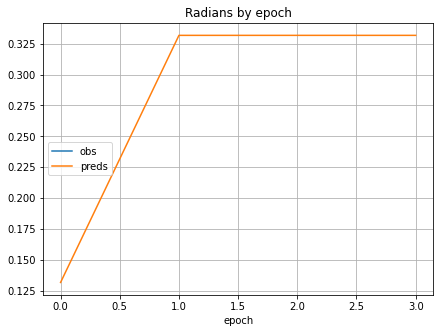

epoch # 1
[-0.15122176  0.38729253 -0.44644641  0.92195689  0.89481037 -3.44234384
  6.64759593 -7.38250383  0.          0.          0.        ] 8.964050513570653 False False {}
obs:  [0.13175052152112757, 0.38729252692918975] 
 preds:  [0.38729253 0.58729253 0.58729253 0.58729253]


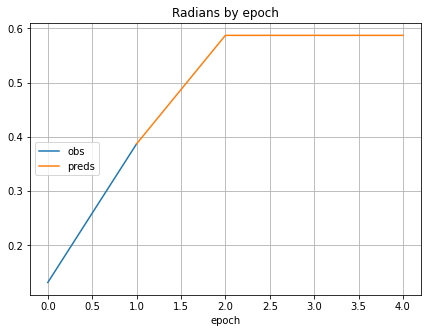

epoch # 2
[-0.36245001  0.70074355 -0.71011791  0.71341325  0.70408277 -4.93414572
  8.1952227  -4.78830142  0.          0.          0.        ] 8.873429871172661 False False {}
obs:  [0.13175052152112757, 0.38729252692918975, 0.7007435541918171] 
 preds:  [0.70074355 0.90074355 0.90074355 0.90074355]


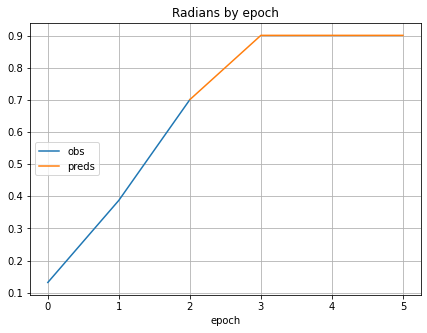

epoch # 3
[-0.60394909  0.91991533 -0.79535908  0.39211706  0.60613854 -4.71653773
  7.43645647 -0.39536331  0.          0.          0.        ] 8.544056365410551 True False {}
obs:  [0.13175052152112757, 0.38729252692918975, 0.7007435541918171, 0.9199153266941007] 
 preds:  [0.91991533 1.11991533 1.11991533 1.11991533]


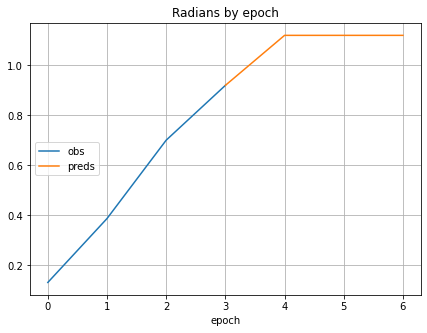

[0.13175052152112757, 0.38729252692918975, 0.7007435541918171, 0.9199153266941007]
Prediction error in last 3 steps:  0.5008130528111538


In [5]:
#@title Live plot an episode for how feature_1 progresses (blue line) and a naive predictor (orange line)

from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

def live_plot(data_dict, figsize=(7,5), title=''):
    # clear_output(wait=True)
    plt.figure(figsize=figsize)
    # for label,data in data_dict.items():
    obs = data_dict["obs"]
    preds = data_dict["preds"]
    print("obs: ", obs, "\n preds: ",preds)

    plt.plot(obs, label="obs")
    plt.plot(range(len(obs)-1, len(obs)+len(preds)-1), preds, label="preds")
    
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

# naive forecaster where we predict the angle at the next 3 steps is the same as the current angle
def naive_forecaster(X):
    # X is the all data known to the forecaster at the time. X is only the current and previous angles for now.
    
    current_angle = X[-1]
    angle_t_plus_1 = current_angle
    angle_t_plus_2 = current_angle
    angle_t_plus_3 = current_angle
    
    return np.array([angle_t_plus_1, angle_t_plus_2, angle_t_plus_3])

obs_history = []

for _ in range(10):
    print("epoch #", _)
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    print(observation, reward, terminated, truncated, info)
    obs_history.append(observation[1])
    preds = obs_history[-1]+[0, 0.2,0.2,0.2]
    live_plot({"obs": obs_history, "preds": preds}, title="Radians by epoch")
    time.sleep(1)
    if terminated or truncated:
        print(obs_history)
        print("Prediction error in last 3 steps: ", forecast_error(obs_history[-3:], preds[-3:]))
        break

env.close()

In [6]:
#@title Define utility fn for running an episode

def create_rows_for_episode(ep_num):
  env.reset(seed=42)
  for _ in range(100):
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    features = np.array(observation[:8]).reshape(1, 8)
    if _ == 0:
      rows_for_ep = features
    else:
      rows_for_ep = np.concatenate((rows_for_ep, features), axis=0)
    if terminated or truncated:
      labels = np.array(range(_, -1,-1)).reshape(_+1, 1)
      ep_num_arr = np.array([ep_num for i in range(len(labels))]).reshape(_+1, 1)
      assert len(labels) == len(rows_for_ep)
      rows_for_ep = np.concatenate((rows_for_ep, labels), axis=1)
      rows_for_ep = np.concatenate((rows_for_ep, ep_num_arr), axis=1)
      # print(len(rows_for_ep), type(rows_for_ep))
      return rows_for_ep
  
    

In [8]:
#@title Create a dataset with positions of the pendulum as features and time to terminate as label by running for X eps

columns = []
for i in range(8):
  columns.append(f'feature_{i}')
columns.append('time_to_terminate')
columns.append('ep_num')

#create array
num_episodes = 10000
for j in range(num_episodes):
  episode_rows = create_rows_for_episode(j)
  if j == 0:
    arr = episode_rows
  else:
    arr = np.concatenate([arr, episode_rows], axis=0)
env.close()

df = pd.DataFrame(arr, columns=columns)
print(df.head())
print(df.describe())
print(df.info())

   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.073560  -0.052753   0.107658   0.998608   0.994188   0.658050   
1   0.146236  -0.206033   0.287723   0.978545   0.957714   2.236974   
2   0.290104  -0.477149   0.567473   0.878823   0.823392   3.472895   
3   0.478987  -0.749220   0.756648   0.662321   0.653823   4.049672   
4   0.029349   0.038108  -0.007219   0.999274   0.999974  -1.113699   

   feature_6  feature_7  time_to_terminate  ep_num  
0  -1.436422   1.590041                3.0     0.0  
1  -4.684512   5.542180                2.0     0.0  
2  -6.698059   6.253761                1.0     0.0  
3  -7.179982   3.607439                0.0     0.0  
4   2.230035  -3.079006                5.0     1.0  
          feature_0     feature_1     feature_2     feature_3     feature_4  \
count  63284.000000  63284.000000  63284.000000  63284.000000  63284.000000   
mean       0.054438     -0.034597      0.065598      0.886637      0.817206   
std        0.22543

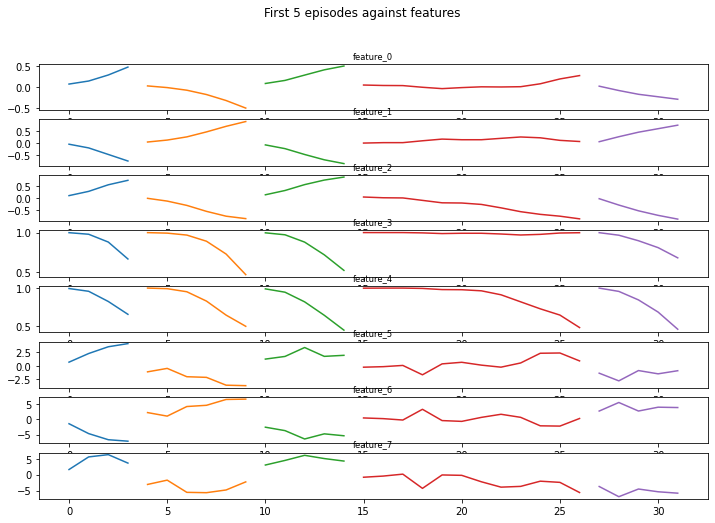

In [9]:
#@title Plot first five episodes trajectories against all features

ep_split_df = [df[df['ep_num']==i] for i in range(5)]
num_features = 8
fig, axs = plt.subplots(num_features, figsize=(12, 8))
plt.suptitle('First 5 episodes against features')
for i in range(num_features):
  for el in ep_split_df:
    ep = el['ep_num'].values[0]
    axs[i].plot(el[f'feature_{i}'], label=f'episode_{int(ep)}')
    axs[i].set_title(f'feature_{i}', fontsize='small')
# plt.legend(loc='right')
plt.show()

In [10]:
#@title Prepare dataset into train, validate, test splits

from random import triangular

test_size = 0.2*num_episodes
valid_size = 0.1*num_episodes
train_size = num_episodes - (test_size+valid_size)

test_df = df[df['ep_num']<=test_size]
valid_df = df[(df['ep_num']>test_size)&(df['ep_num']<=(valid_size+test_size))]
train_df = df[(df['ep_num']>(valid_size+test_size))]

features = []
for i in range(8):
  features.append(f'feature_{i}')

test_labels = test_df['time_to_terminate']
test_features = test_df[features]

valid_labels = valid_df['time_to_terminate']
valid_features = valid_df[features]

train_labels = train_df['time_to_terminate']
train_features = train_df[features]

print('Test dataset shapes:', test_labels.shape, test_features.shape)
print('Validation dataset shapes:', valid_labels.shape, valid_features.shape)
print('Train dataset shapes:', train_labels.shape, train_features.shape)

Test dataset shapes: (12760,) (12760, 8)
Validation dataset shapes: (6241,) (6241, 8)
Train dataset shapes: (44283,) (44283, 8)


In [14]:
#@title Create linear regression model to predict time_to_terminate using features as baseline. This model does not take into account the time series i.e. it assumes that t, t+1 are independent

from sklearn.linear_model import LinearRegression

regr = LinearRegression()

regr.fit(train_features, train_labels)

preds = regr.predict(test_features)

print('RMSE: \n', forecast_error(test_labels, preds))
print('Score: \n', regr.score(test_features, test_labels))
print('Betas: \n', regr.coef_, '\n Intercept: \n',regr.intercept_)


RMSE: 
 1.522571052449443
Score: 
 0.5933053992609192
Betas: 
 [ 8.34255204  7.30076246  2.8854539   4.85335042  5.34934277 -0.06200776
  0.02376763  0.02941992] 
 Intercept: 
 -6.120034085663619


In [17]:
#@title Try linear model but set preds less than zero to 0
preds_positive = preds.copy()
preds_positive[preds_positive < 0] =  0

print('Positive only predictions linear model')
print('RMSE: \n', forecast_error(test_labels, preds_positive))


Positive only predictions linear model
RMSE: 
 1.4851893811083783


In [15]:
#@title Linear model outputs (-inf, inf) but data is [0, inf). Create Poisson Regression model for linear regression but positive predictions

from sklearn.linear_model import PoissonRegressor

pois_regr = PoissonRegressor()

pois_regr.fit(train_features, train_labels)

pois_preds = pois_regr.predict(test_features)
print('Poisson model')
print('RMSE: \n', forecast_error(test_labels, pois_preds))
print('Score: \n', pois_regr.score(test_features, test_labels))

Poisson model
RMSE: 
 2.193153306749734
Score: 
 0.14896495041607305


In [16]:
#@title Tweedie model generalised linear model. Power=1.5 is between a gamma and poisson regression model

from sklearn.linear_model import TweedieRegressor

tweed_regr = TweedieRegressor(power=1.5)

tweed_regr.fit(train_features, train_labels)

tweed_preds = tweed_regr.predict(test_features)
print('Tweedie w/ power=1.5')
print('RMSE: \n', forecast_error(test_labels, tweed_preds))
print('Score: \n', tweed_regr.score(test_features, test_labels))

Tweedie w/ power=1.5
RMSE: 
 2.2644318767825373
Score: 
 0.07035204166707842


In [20]:
#@title Linear models by definition fit the output linearly to featrues. Intuition tells us that a good model should enable e.g. x^2 features as the direction (+/-) of the position features does not matter for falling for pendulum. NNs are good for this. We use softplus for output [0, inf)
from torch import nn

class DenseNet(nn.Module):
  def __init__(self):
    super(DenseNet, self).__init__()
    self.layer1 = nn.Linear(8,20)
    self.layer2 = nn.Linear(20,1)
    self.softplus = nn.Softplus()
  
  def forward(self, X):
    hidden1 = self.layer1(X)
    hidden2 = self.layer2(hidden1)

    output = self.softplus(hidden2)
    return output

dense_model = DenseNet()
print(dense_model)

DenseNet(
  (layer1): Linear(in_features=8, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=1, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
)


In [21]:
#@title Test fwd pass of NN with vector of 1s
X_fwd_pass = torch.ones(1, 8, dtype=torch.float32, device='cpu')
dense_model(X_fwd_pass)

tensor([[0.5598]], grad_fn=<SoftplusBackward0>)

In [22]:
#@title Preprocess episodes dataset into pytorch tensors

dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device: \n', device)

train_labels_tensor = torch.tensor(train_labels.values, dtype=dtype, device=device).view(len(train_labels), -1)
train_features_tensor = torch.tensor(train_features.values, dtype=dtype, device=device, requires_grad=True)

valid_labels_tensor = torch.tensor(valid_labels.values, dtype=dtype, device=device).view(len(valid_labels), -1)
valid_features_tensor = torch.tensor(valid_features.values, dtype=dtype, device=device)

test_labels_tensor = torch.tensor(test_labels.values, dtype=dtype, device=device).view(len(test_labels), -1)
test_features_tensor = torch.tensor(test_features.values, dtype=dtype, device=device)

print('Test tensor shapes:', test_labels_tensor.shape, test_features_tensor.shape)
print('Validation tensor shapes:', valid_labels_tensor.shape, valid_features_tensor.shape)
print('Train tensor shapes:', train_labels_tensor.shape, train_features_tensor.shape)

Using device: 
 cuda
Test tensor shapes: torch.Size([12760, 1]) torch.Size([12760, 8])
Validation tensor shapes: torch.Size([6241, 1]) torch.Size([6241, 8])
Train tensor shapes: torch.Size([44283, 1]) torch.Size([44283, 8])


In [23]:
#@title Define the training loop fn for the NN

def train(y_train, X_train, y_valid, X_valid, y_test, X_test, model_, \
          model_name, epochs=10000, learning_rate=0.1):
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model_.parameters(), lr=learning_rate)
  model_.name = model_name
  for epoch in range(epochs):
    optimizer.zero_grad()

    train_preds = model_(X_train)
    train_loss = torch.sqrt(criterion(train_preds, y_train))
    if epoch % 500 == 0:
      valid_preds = model_(X_valid)
      valid_loss = torch.sqrt(criterion(valid_preds, y_valid))
      print(f'epoch #{epoch} \n training loss: \n', train_loss.item(), \
            '\n validation loss: \n', valid_loss.item(), '\n')
    train_loss.backward()
    optimizer.step()

  test_preds = model_(X_test)
  test_loss = torch.sqrt(criterion(test_preds, y_test))

  print('Final metrics: \n training loss: ', train_loss.item(), \
        '\n validation loss: ', valid_loss.item(),'\n test loss: ', \
        test_loss.item())


In [24]:
#@title Put model onto GPU and run training loop

dense_model.to(device)

train(train_labels_tensor, train_features_tensor, valid_labels_tensor, valid_features_tensor, \
      test_labels_tensor, test_features_tensor, dense_model, model_name='10000eps_DenseNet_10000epochs', epochs=10000)

epoch #0 
 training loss: 
 3.1400301456451416 
 validation loss: 
 3.0436501502990723 

epoch #500 
 training loss: 
 1.7226183414459229 
 validation loss: 
 1.663612961769104 

epoch #1000 
 training loss: 
 1.5462509393692017 
 validation loss: 
 1.486640214920044 

epoch #1500 
 training loss: 
 1.5732628107070923 
 validation loss: 
 1.476595163345337 

epoch #2000 
 training loss: 
 1.5246387720108032 
 validation loss: 
 1.4279407262802124 

epoch #2500 
 training loss: 
 1.498442530632019 
 validation loss: 
 1.4249329566955566 

epoch #3000 
 training loss: 
 1.485600233078003 
 validation loss: 
 1.3904356956481934 

epoch #3500 
 training loss: 
 1.4336216449737549 
 validation loss: 
 1.3584634065628052 

epoch #4000 
 training loss: 
 1.4210160970687866 
 validation loss: 
 1.3270143270492554 

epoch #4500 
 training loss: 
 1.3877894878387451 
 validation loss: 
 1.310279369354248 

epoch #5000 
 training loss: 
 1.3814843893051147 
 validation loss: 
 1.2931663990020752 

In [25]:
#@title Next we add reLU for additional non-linearity to the NN

class DenseNetRelu(nn.Module):
  def __init__(self):
    super(DenseNetRelu, self).__init__()
    self.layer1 = nn.Linear(8,20)
    self.relu1 = nn.ReLU()
    self.layer2 = nn.Linear(20,1)
    self.relu2 = nn.ReLU()
    self.softplus = nn.Softplus()
  
  def forward(self, X):
    hidden1 = self.relu1(self.layer1(X))
    hidden2 = self.relu2(self.layer2(hidden1))

    output = self.softplus(hidden2)
    return output

dense_plus_relu_model = DenseNetRelu()
print(dense_plus_relu_model)

DenseNetRelu(
  (layer1): Linear(in_features=8, out_features=20, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=20, out_features=1, bias=True)
  (relu2): ReLU()
  (softplus): Softplus(beta=1, threshold=20)
)


In [26]:
#@title Put model onto GPU and run training loop

dense_plus_relu_model.to(device)

train(train_labels_tensor, train_features_tensor, valid_labels_tensor, valid_features_tensor, \
      test_labels_tensor, test_features_tensor, dense_plus_relu_model, model_name='10000eps_DenseNetRelu_10000epochs', epochs=10000)

epoch #0 
 training loss: 
 3.2151575088500977 
 validation loss: 
 3.119743585586548 

epoch #500 
 training loss: 
 1.196364164352417 
 validation loss: 
 1.1161489486694336 

epoch #1000 
 training loss: 
 1.1290465593338013 
 validation loss: 
 1.0545544624328613 

epoch #1500 
 training loss: 
 1.1156443357467651 
 validation loss: 
 1.0536611080169678 

epoch #2000 
 training loss: 
 1.0971620082855225 
 validation loss: 
 1.0263288021087646 

epoch #2500 
 training loss: 
 1.1178566217422485 
 validation loss: 
 1.043073058128357 

epoch #3000 
 training loss: 
 1.0780810117721558 
 validation loss: 
 1.0207936763763428 

epoch #3500 
 training loss: 
 1.0748578310012817 
 validation loss: 
 1.0199929475784302 

epoch #4000 
 training loss: 
 1.076829195022583 
 validation loss: 
 1.0207819938659668 

epoch #4500 
 training loss: 
 1.0689733028411865 
 validation loss: 
 1.0015023946762085 

epoch #5000 
 training loss: 
 1.0662684440612793 
 validation loss: 
 1.016301035881042

In [27]:
#@title So far all the models above assume independence between t, t+1 within an episode. LSTM is a RNN which enables learning of this dependency

class LSTMnet(nn.Module):
  def __init__(self, batch_first=True):
    super(LSTMnet, self).__init__()
    self.lstm = nn.LSTM(8, 16)
    self.linear = nn.Linear(16, 1)
    self.softplus = nn.Softplus()
  
  def forward(self, ep_features):
    # embeds.view(len(sentence), 1, -1)) --> ??
    batch_size, ep_length, num_feats = ep_features.size()
    # used to be ep_features.view(len(ep_features),1,-1)
    lstm_out, _ =  self.lstm(ep_features.view(batch_size, -1, num_feats))
    # may also need unpad the upper zeroes
    # lstm_out, _ = self.lstm(ep_features.view(ep_features.size()[0], ep_features.size()[1],1,-1))
 # used to be ep_features.view(len(ep_features), -1)
    linear_out = self.linear(lstm_out.view(batch_size, -1, 16))
    output = self.softplus(linear_out)

    return output

lstm_model = LSTMnet()
lstm_model.to(device)

LSTMnet(
  (lstm): LSTM(8, 16)
  (linear): Linear(in_features=16, out_features=1, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
)

In [29]:
#@title Prepare data for LSTM i.e. shape is [(ep1_features, ep1_labels), (ep2_features, ep2_labels), ...] in tensors

eps = []

for ep_num in range(num_episodes):
  episode = df[df['ep_num']==ep_num]
  episode_feats = torch.tensor(episode[features].values, dtype=dtype, device=device, requires_grad=True)
  episode_labs = torch.tensor(episode['time_to_terminate'].values, dtype=dtype, device=device).view(len(episode),-1)
  eps.append((episode_feats, episode_labs))

assert len(eps) == num_episodes

# split into train, validate, test
test_episodes = eps[:int(test_size)]
valid_episodes = eps[int(test_size): int(test_size)+int(valid_size)]
train_episodes = eps[int(test_size)+int(valid_size):]

print('Number of episodes in train dataset; \n', len(train_episodes),'\n First episode: \n' , train_episodes[0])

assert len(test_episodes)+ len(valid_episodes)+len(train_episodes) == len(eps)

Number of episodes in train dataset; 
 7000 
 First episode: 
 (tensor([[ 6.4463e-02, -3.4131e-02,  8.4303e-02,  9.9942e-01,  9.9644e-01,
          2.9376e-01, -6.8737e-01,  6.4675e-01],
        [ 4.3722e-02,  1.0553e-03,  3.3870e-02,  1.0000e+00,  9.9943e-01,
         -1.1253e+00,  2.1118e+00, -2.7083e+00],
        [-2.8974e-02,  1.4023e-01, -1.4311e-01,  9.9012e-01,  9.8971e-01,
         -1.7832e+00,  3.4983e+00, -4.4294e+00],
        [-1.2567e-01,  3.2813e-01, -3.7670e-01,  9.4463e-01,  9.2633e-01,
         -2.0788e+00,  4.2390e+00, -5.2099e+00],
        [-2.2303e-01,  5.1679e-01, -5.9901e-01,  8.5611e-01,  8.0074e-01,
         -1.8176e+00,  4.1573e+00, -5.0966e+00],
        [-3.4295e-01,  7.1371e-01, -7.7992e-01,  7.0044e-01,  6.2587e-01,
         -2.9456e+00,  5.7782e+00, -4.5535e+00],
        [-4.8157e-01,  8.8408e-01, -8.8985e-01,  4.6733e-01,  4.5625e-01,
         -2.5947e+00,  5.8530e+00, -3.5584e+00]], device='cuda:0',
       requires_grad=True), tensor([[6.],
        [5.],
 

In [32]:
#@title LSTM is much slower to train than fully connected NN so we need to enable training in batches i.e. multiple forward passes and backward steps in parallel. We process the data to create these batches
from torch.utils.data import Dataset

class EpisodesDataset(Dataset):
    def __init__(self, episode_feats, episode_labs):
        self.episode_feats = episode_feats
        self.episode_labs = episode_labs

    def __len__(self):
        return len(self.episode_labs)

    def __getitem__(self, idx):
        return self.episode_feats[idx], self.episode_labs[idx]

def ep_data_to_pytorch_dataset(ep_data):
  all_episode_feats = [ep_data[i][0] for i in range(len(ep_data))]
  all_episode_labs = [ep_data[i][1] for i in range(len(ep_data))]
  pytorch_dataset = EpisodesDataset(all_episode_feats, all_episode_labs)
  return pytorch_dataset

train_dataset = ep_data_to_pytorch_dataset(train_episodes)
valid_dataset = ep_data_to_pytorch_dataset(valid_episodes)
test_dataset = ep_data_to_pytorch_dataset(test_episodes)

print('Number of train dataset rows post processing: \n', len(train_dataset))

Number of train dataset rows post processing: 
 7000


In [34]:
#@title In order to create batches we need pad the dataset with zeros so that each episode is the same length. We need to find max ep length, pad the dataset and then create PyTorch Dataloader objects to enable batch training
from torch.utils.data import DataLoader

MAX_EP_LENGTH = 1
for ep in eps:
  if len(ep[0])>MAX_EP_LENGTH:
    MAX_EP_LENGTH = len(ep[0])

print('Maximum episode length in dataset: \n', MAX_EP_LENGTH)

def ep_data_to_padded_pytorch_dataset(ep_data, max_ep_length):
  padded_all_episode_feats = []
  padded_all_episode_labs = []
  for i in range(len(ep_data)):
    ep_feats = ep_data[i][0]
    ep_labs = ep_data[i][1]
    if len(ep_feats) != max_ep_length:
      num_zeros = max_ep_length - len(ep_feats)
      pad_feats_arr = np.zeros((num_zeros, ep_feats.shape[1]))
      pad_labs_arr = np.zeros((num_zeros, ep_labs.shape[1]))
      ep_feats = torch.cat((torch.tensor(pad_feats_arr, dtype=dtype, device=device), ep_feats), dim=0)
      ep_labs = torch.cat((torch.tensor(pad_labs_arr, dtype=dtype, device=device), ep_labs), dim=0)

    padded_all_episode_feats.append(ep_feats)
    padded_all_episode_labs.append(ep_labs)
  
  padded_pytorch_dataset = EpisodesDataset(padded_all_episode_feats, padded_all_episode_labs)
  return padded_pytorch_dataset

padded_train_dataset = ep_data_to_padded_pytorch_dataset(train_episodes, MAX_EP_LENGTH)
padded_valid_dataset = ep_data_to_padded_pytorch_dataset(valid_episodes, MAX_EP_LENGTH)
padded_test_dataset = ep_data_to_padded_pytorch_dataset(test_episodes, MAX_EP_LENGTH)

BATCH_SIZE=256

train_dataloader = DataLoader(padded_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(padded_valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(padded_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Maximum episode length in dataset: 
 17
Feature batch shape: torch.Size([256, 17, 8])
Labels batch shape: torch.Size([256, 17, 1])


In [35]:
#@title Test LSTM output with single sample

out = lstm_model(train_features)
print('Model outputs data with shape: \n', out.size())

Model outputs data with shape: 
 torch.Size([256, 17, 1])


In [36]:
#@title Create utility fn for LSTM training loop with batches
from tqdm import tqdm

def lstm_train(train_eps, valid_eps, test_eps, model_, model_name, epochs=10000, learning_rate=0.1):
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model_.parameters(), lr=learning_rate)
  model_.name = model_name
  for epoch, _ in enumerate(tqdm(range(epochs))):
    start_time = time.time()
    train_loss_sum_sq = 0.
    for step, (ep_features, ep_labels) in enumerate(train_eps):
      optimizer.zero_grad()
      ep_preds = model_(ep_features)
      ep_loss = torch.sqrt(criterion(ep_preds, ep_labels))

      train_loss_sum_sq+=criterion(ep_preds, ep_labels).item()*len(ep_labels)

      ep_loss.backward()
      optimizer.step()
    if epoch % 1000 == 0:
      valid_loss_sum_sq = 0.
      for step, (ep_features, ep_labels) in enumerate(valid_eps):
        valid_preds = model_(ep_features)
        valid_loss_sum_sq +=criterion(valid_preds, ep_labels).item()*len(ep_labels)
      elapsed_time = time.time() - start_time
      print(f'epoch #{epoch} \n training loss: \n', np.sqrt(train_loss_sum_sq / len(train_eps)), \
          '\n validation loss: \n', np.sqrt(valid_loss_sum_sq / len(valid_eps)), '\n elapsed time: \n', elapsed_time)
  
  test_loss_sum_sq = 0.
  for ep_features, ep_labels in test_eps:
    test_preds = model_(ep_features)
    test_loss_sum_sq +=criterion(test_preds, ep_labels).item()*len(ep_labels)

  print('Final metrics: \n training loss: \n', np.sqrt(train_loss_sum_sq / len(train_eps)), \
          '\n validation loss: \n', np.sqrt(valid_loss_sum_sq / len(valid_eps)), \
        '\n test loss: \n', np.sqrt(test_loss_sum_sq / len(test_eps)))

In [38]:
#@title Run training loop

lstm_train(train_dataloader, valid_dataloader, test_dataloader, lstm_model, model_name='10000eps_LSTMnet_1000epochs', epochs=1000)

  0%|          | 1/1000 [00:00<03:36,  4.61it/s]

epoch #0 
 training loss: 
 5.503088371976263 
 validation loss: 
 5.316283689175097 
 elapsed time: 
 0.21559500694274902


100%|██████████| 1000/1000 [03:51<00:00,  4.31it/s]

Final metrics: 
 training loss: 
 2.28666863145205 
 validation loss: 
 5.316283689175097 
 test loss: 
 2.9579520536691746


In [42]:
#@title Sample from test dataset and compare all models

sample = test_df.sample()
sample_feat = sample[features]
sample_lab = sample['time_to_terminate']
print('Linear model: ',regr.predict(sample_feat)[0])
print('Poisson model: ', pois_regr.predict(sample_feat)[0])
print('DenseNet model: ', dense_model(torch.tensor(sample_feat.values, dtype=dtype, device=device)).item())
print('DenseNetRelu model: ', dense_plus_relu_model(torch.tensor(sample_feat.values, dtype=dtype, device=device)).item())
print('LSTM model: ', lstm_model(torch.tensor(sample_feat.values.reshape(1,len(sample_feat), 8), dtype=dtype, device=device)).item())
print('Actual:  ', sample_lab.values[0])

Linear model:  4.604528151081752
Poisson model:  3.2605485153673204
DenseNet model:  5.21165657043457
DenseNetRelu model:  4.672582149505615
LSTM model:  4.790176868438721
Actual:   4.0


In [47]:
#@title Save all models locally and to Gdrive

from google.colab import drive
from os.path import join

def save_models(model_list, dir):
  for model__ in model_list:
    model_file_name = f'{model__.name}.pt'
    torch.save(model__.state_dict(), dir+'/'+model_file_name)
  return f'Models saved to local /{dir} directory', dir

!mkdir models

save_models([dense_model, dense_plus_relu_model, lstm_model], 'models')

# copy models dir to Gdrive

ROOT = '/content/drive'
drive.mount(ROOT)

PROJ = 'MyDrive/LearningPhysics/Models'
PROJECT_PATH = join(ROOT, PROJ)
print('Copied models to Gdrive directory at', PROJECT_PATH)
!cp -r models {PROJECT_PATH}

mkdir: cannot create directory ‘models’: File exists
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copied models to Gdrive directory at /content/drive/MyDrive/LearningPhysics/Models
